In [ ]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

DATASET_PATCH = pt(os.getcwd()) / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))
test_data

,id
0,30001.opus
1,30002.opus
2,30003.opus
3,30004.opus
4,30005.opus
...,...
4995,34996.opus
4996,34997.opus
4997,34998.opus
4998,34999.opus


In [ ]:
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"

In [ ]:
# Поятоянные значения выявленные в процессе анализа
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 160

FREQ_MASK = 30
TIME_MASK = 40

In [15]:
print(torch.__version__)
print(torchaudio.__version__)

2.7.0+cu128
2.7.0+cu128


## Проверка информации о файлах

In [4]:
metadata_list = []

for audio_file in sorted(AUDIO_FILES.iterdir()):
    metadata = torchaudio.info(audio_file)

    metadata_list.append({
        'filename': audio_file.name,
        'sample_rate': metadata.sample_rate,
        'num_frames': metadata.num_frames,
        'duration_sec': metadata.num_frames / metadata.sample_rate,
        'num_channels': metadata.num_channels,
        'bits_per_sample': metadata.bits_per_sample,
        'encoding': metadata.encoding
        })
        
df = pd.DataFrame(metadata_list)

c:\Users\homer\OneDrive\Desktop\Morse Decoder_V2\Morse_decoder_V2\Lib\site-packages\torchaudio\_backend\soundfile_backend.py:71: UserWarning: The OPUS subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
  warnings.warn(


In [5]:
df.describe()


,sample_rate,num_frames,duration_sec,num_channels,bits_per_sample
count,35000.0,35000.000000,35000.000000,35000.0,35000.0
mean,8000.0,64155.428571,8.019429,1.0,0.0
std,0.0,7050.844292,0.881356,0.0,0.0
min,8000.0,64000.000000,8.000000,1.0,0.0
25%,8000.0,64000.000000,8.000000,1.0,0.0
50%,8000.0,64000.000000,8.000000,1.0,0.0
75%,8000.0,64000.000000,8.000000,1.0,0.0
max,8000.0,384000.000000,48.000000,1.0,0.0


In [6]:
df[df.duration_sec != 8] # => все остальные файлы нуджно растянуть до максимальной длины

,filename,sample_rate,num_frames,duration_sec,num_channels,bits_per_sample,encoding
27761,34984.opus,8000,384000,48.0,1,0,UNKNOWN
27762,34985.opus,8000,384000,48.0,1,0,UNKNOWN
27763,34986.opus,8000,384000,48.0,1,0,UNKNOWN
27764,34987.opus,8000,384000,48.0,1,0,UNKNOWN
27765,34988.opus,8000,384000,48.0,1,0,UNKNOWN
27766,34989.opus,8000,384000,48.0,1,0,UNKNOWN
27768,34990.opus,8000,384000,48.0,1,0,UNKNOWN
27769,34991.opus,8000,384000,48.0,1,0,UNKNOWN
27770,34992.opus,8000,384000,48.0,1,0,UNKNOWN
27771,34993.opus,8000,384000,48.0,1,0,UNKNOWN


# 17 файлов отличаются длинной 
=> для корректоного обучения нужно растянуть все аудио файлы до 48 секцнд (Например тишиной)

-----------------------

# Сравнительный анализ файлов 8 и 48 секунд. Тестирование функций предобработки.

In [ ]:
waveform_8, sample_rate_8 = torchaudio.load(AUDIO_FILES / '30002.opus')
waveform_48, sample_rate_48 = torchaudio.load(AUDIO_FILES / '35000.opus')

In [53]:
waveform_8.shape

torch.Size([1, 64000])

In [54]:
torch.zeros(50).fill_(2).shape

torch.Size([50])

In [62]:
a = waveform_8
b = torch.zeros(50).fill_(2).unsqueeze(0)

torch.cat([a,b], dim=1).shape


torch.Size([1, 64050])

In [65]:
def change_time(audio_file, max_len = 384000):
    # metadata = torchaudio.info(audio_file)
    # duration_sec = metadata.num_frames / metadata.sample_rate
    waveform, sample_rate = torchaudio.load(audio_file)
    cahanal, sig_len = waveform.shape

    if sig_len < max_len:
        pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
        waveform = torch.cat([waveform, pad_len], dim=1)

    return waveform, sample_rate


waveform_8, sample_rate_8 = change_time(AUDIO_FILES / '30002.opus')

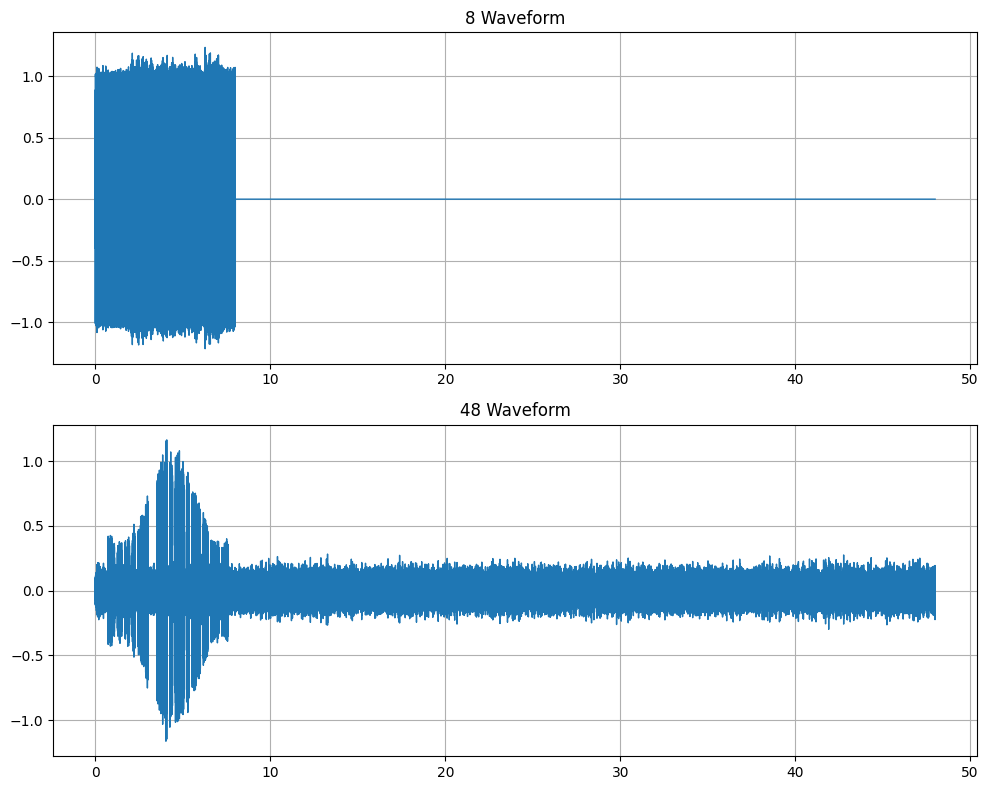

In [66]:
def plot_waveforms(waveforms, sample_rates, titles=None):
    num_waveforms = len(waveforms)
    if titles is None:
        titles = [f"Waveform {i+1}" for i in range(num_waveforms)]
    
    fig, axes = plt.subplots(num_waveforms, 1, figsize=(10, 4 * num_waveforms))
    if num_waveforms == 1:
        axes = [axes]
    
    for i, (waveform, sample_rate, title) in enumerate(zip(waveforms, sample_rates, titles)):
        if type(waveform) is not np.ndarray:
            waveform = waveform.numpy()
            
        num_channels, num_frames = waveform.shape
        time_axis = torch.arange(0, num_frames) / sample_rate
        
        for c in range(num_channels):
            axes[i].plot(time_axis, waveform[c], linewidth=1, label=f"Channel {c+1}")
            axes[i].grid(True)
            if num_channels > 1:
                axes[i].legend()
        axes[i].set_title(title)
    
    plt.tight_layout()
    plt.show()

plot_waveforms([waveform_8, waveform_48], [sample_rate_8, sample_rate_48], ["8 Waveform", "48 Waveform"])

Из анализа видно что ВСЕ аудиофайлы длинной 8 секунд сильно зашумлены. => нужно фиотрация частот.

Filtered audio shape: (1, 64000)


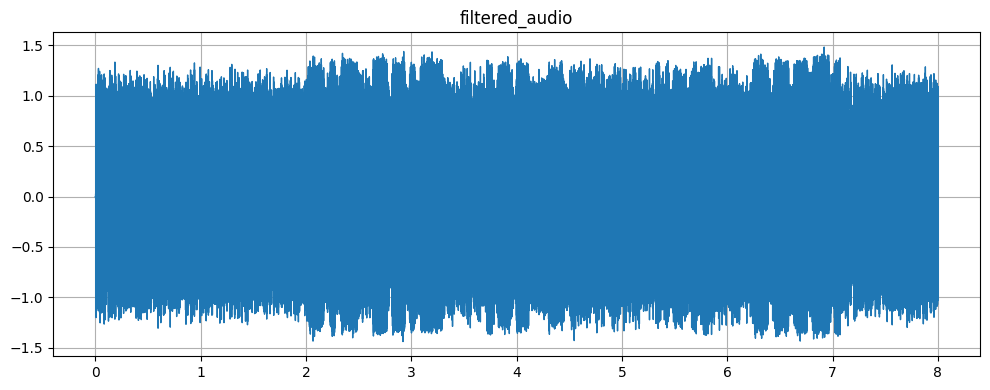

In [12]:
def butter_lowpass_filter(data, cutoff_freq, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    print(f"Filtered audio shape: {filtered_data.shape}")
    return filtered_data

filtered_audio = butter_lowpass_filter(waveform_8, cutoff_freq=3000, sample_rate=SAMPLE_RATE)
filtered_audio
plot_waveforms([filtered_audio],[8000],['filtered_audio'])

# Построим спектрограммы и проверим вляние филтрации

c:\Users\homer\OneDrive\Desktop\Morse Decoder_V2\Morse_decoder_V2\Lib\site-packages\matplotlib\axes\_axes.py:8264: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


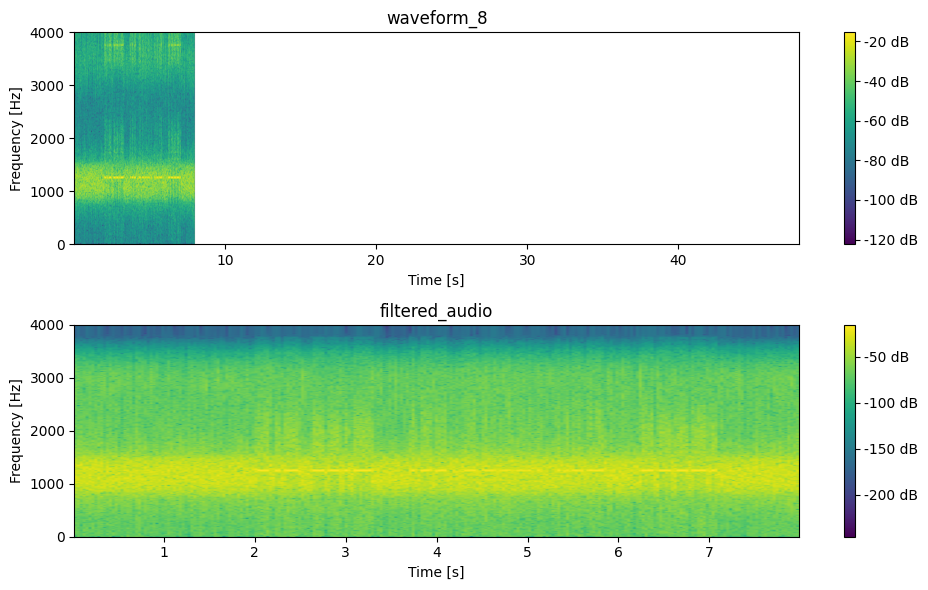

In [67]:
def plot_specgrams(waveforms, sample_rates, titles=None, figsize=(10, 6)):
    num_waveforms = len(waveforms)
    if titles is None:
        titles = [f"Spectrogram {i+1}" for i in range(num_waveforms)]
    
    fig, axes = plt.subplots(num_waveforms, 1, figsize=figsize)
    if num_waveforms == 1:
        axes = [axes]
    
    for i, (waveform, sample_rate, title) in enumerate(zip(waveforms, sample_rates, titles)):
        if type(waveform) is not np.ndarray:
            waveform = waveform.numpy()
            
        num_channels, _ = waveform.shape
        
        for c in range(num_channels):
            axes[i].specgram(
                waveform[c],
                Fs=sample_rate,
                cmap='viridis',
                NFFT=512,
                noverlap=256,
                scale='dB'
            )
            axes[i].set_title(title)
            axes[i].set_xlabel('Time [s]')
            axes[i].set_ylabel('Frequency [Hz]')
            
            plt.colorbar(
                axes[i].images[0],
                ax=axes[i],
                format='%+2.0f dB'
            )
    
    plt.tight_layout()
    plt.show()

plot_specgrams([waveform_8, filtered_audio], [8000, 8000], ['waveform_8', 'filtered_audio'])

# MEL Спектрограммы

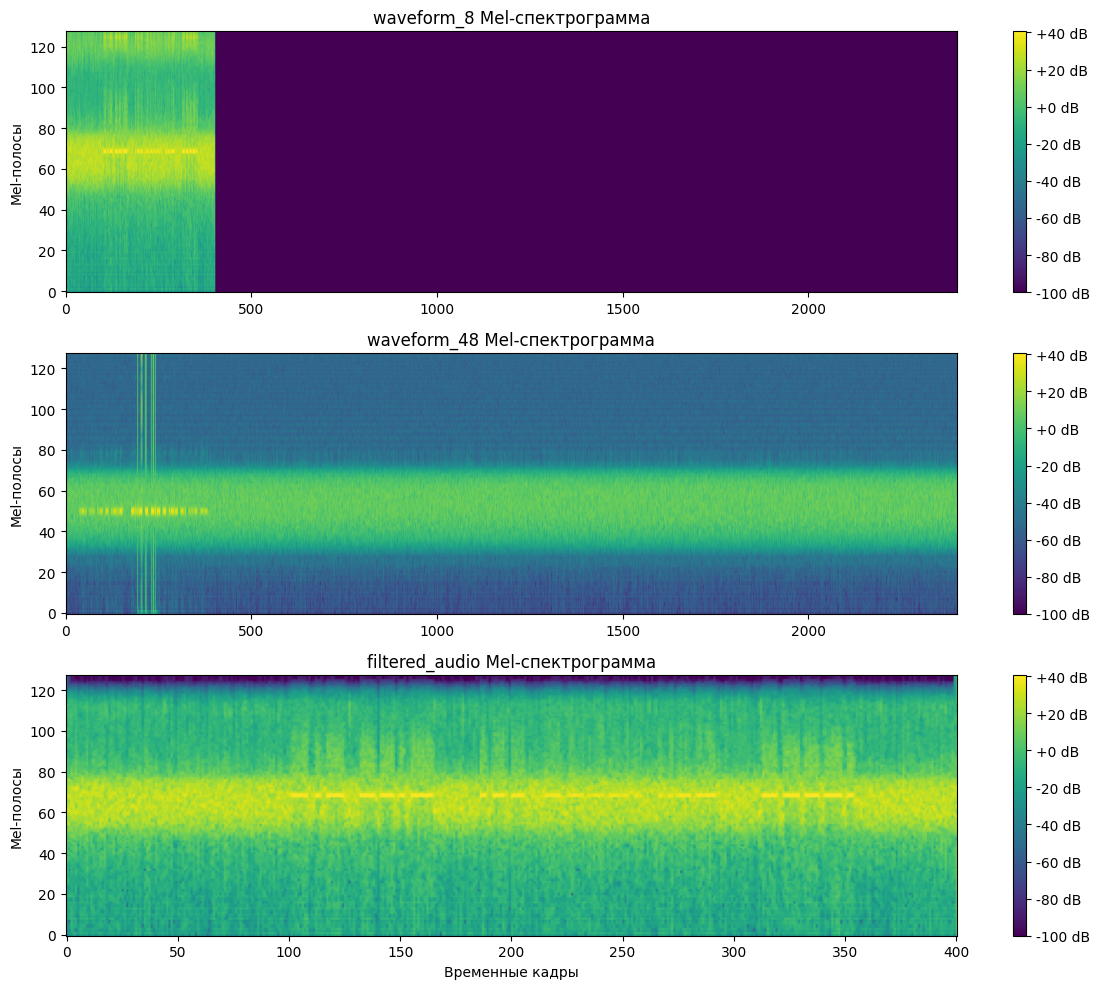

In [68]:
spec = transforms.MelSpectrogram(SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

waveform_8_mel_spec = spec(waveform_8)
waveform_8_log_mel_spec = torchaudio.transforms.AmplitudeToDB()(waveform_8_mel_spec)

waveform_48_mel_spec = spec(waveform_48)
waveform_48_log_mel_spec = torchaudio.transforms.AmplitudeToDB()(waveform_48_mel_spec)

fe_tensor = torch.FloatTensor(filtered_audio.copy())
filtered_audio_mel_spec = spec(fe_tensor)
filtered_audio_log_mel_spec = torchaudio.transforms.AmplitudeToDB()(filtered_audio_mel_spec)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

vmin = min(waveform_8_log_mel_spec.min(), waveform_48_log_mel_spec.min(), filtered_audio_log_mel_spec.min())
vmax = max(waveform_8_log_mel_spec.max(), waveform_48_log_mel_spec.max(), filtered_audio_log_mel_spec.max())

# waveform_8
im1 = ax1.imshow(
    waveform_8_log_mel_spec[0].numpy(),
    aspect="auto",
    origin="lower",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("waveform_8 Mel-спектрограмма")
ax1.set_ylabel("Mel-полосы")
fig.colorbar(im1, ax=ax1, format="%+2.0f dB")

# waveform_48
im2 = ax2.imshow(
    waveform_48_log_mel_spec[0].numpy(),
    aspect="auto",
    origin="lower",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("waveform_48 Mel-спектрограмма")
ax2.set_ylabel("Mel-полосы")
fig.colorbar(im2, ax=ax2, format="%+2.0f dB")

# filtered_audio
im3 = ax3.imshow(
    filtered_audio_log_mel_spec[0].numpy(),
    aspect="auto",
    origin="lower",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax3.set_title("filtered_audio Mel-спектрограмма")
ax3.set_xlabel("Временные кадры")
ax3.set_ylabel("Mel-полосы")
fig.colorbar(im3, ax=ax3, format="%+2.0f dB")

plt.tight_layout()
plt.show()

# Попытка очистить от шума не привела к значительным изменениям в MEL-спектрограмме => Не будем применятьл данный метод
------------------------

Трансформации изображения для обучения модели

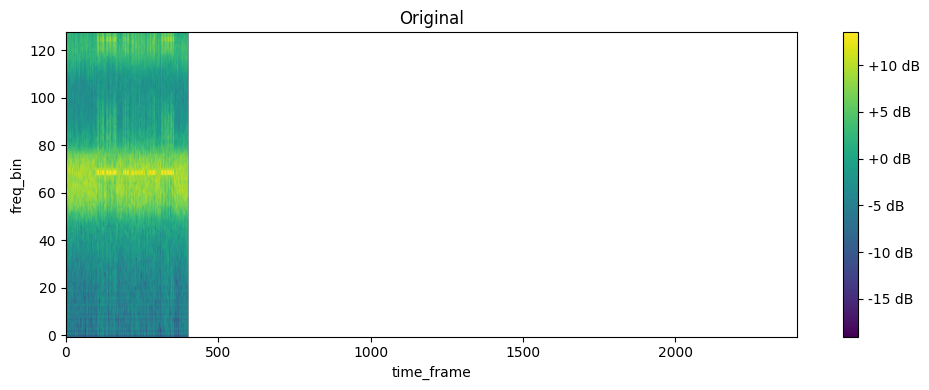

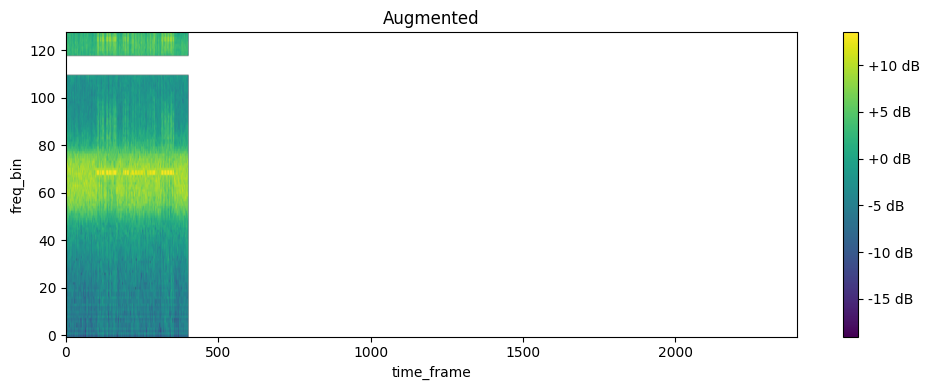

torch.Size([1, 128, 2401]) torch.Size([1, 128, 2401])


In [70]:
def view_melspec(spec, title=None, ylabel="freq_bin"):
    plt.figure(figsize=(10, 4))
    plt.imshow(spec.log2()[0, :, :].numpy(), cmap="viridis", origin="lower", aspect="auto")
    plt.colorbar(format="%+2.0f dB")
    if title:
        plt.title(title)
    plt.xlabel("time_frame")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

train_audio_transform = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK)
)
augmented_spectrogram = train_audio_transform(waveform_8)


view_melspec(waveform_8_mel_spec, title="Original")
view_melspec(augmented_spectrogram, title="Augmented")

print(waveform_8_mel_spec.shape, augmented_spectrogram.shape)

# По итогу анализа, Dataset будет сотоять из: загрузки + изменения длиы -> получение спектрограммы -> Применение аугментаций.